In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import stft
import scipy.fft
from scipy.fftpack import fft
import pywt
import pywt.data
import math
import statsmodels.api as sm
import csv
from scipy.signal import spectrogram
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

### 0
Был взят датасет учета рабочего времени prac_4_oot.csv
Набор данных учета рабочего времени состоит из:
- Время работы сотрудника (train) в минутах
- Дата (date)
- id сотрудника

In [2]:
train_data =  pd.read_csv('prac_4_oot.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.head()

,total,date,id
0,153.399444,2020-02-01,13010
1,143.204444,2020-02-02,13010
2,303.795556,2020-02-03,13010
3,296.877778,2020-02-04,13010
4,293.414722,2020-02-05,13010


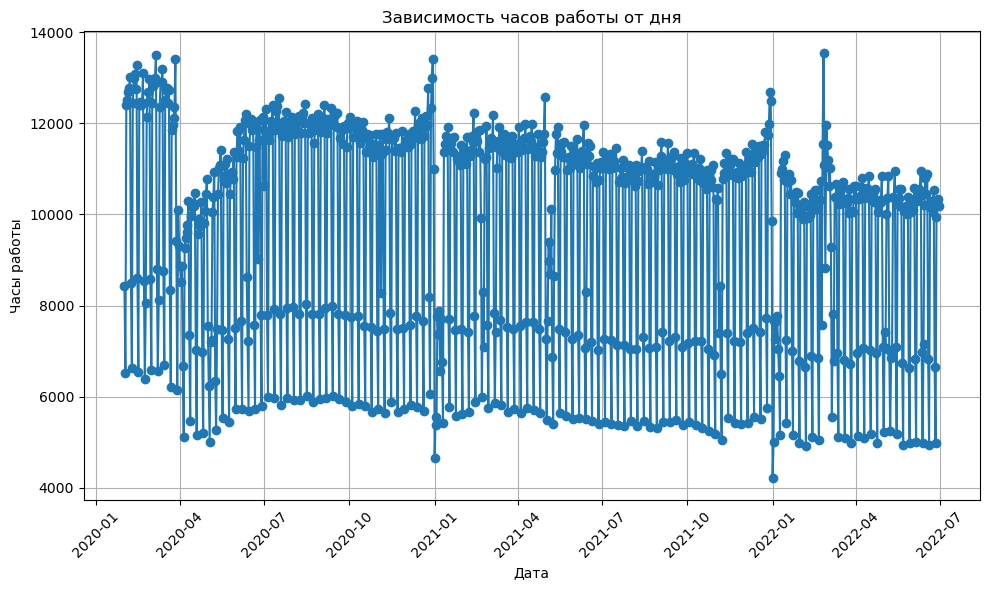

<Figure size 640x480 with 0 Axes>

In [3]:
grouped_data = train_data.groupby('date')['total'].sum().reset_index()

# Построение графика зависимости часов работы от дня
plt.figure(figsize=(10, 6))
plt.plot(grouped_data['date'],grouped_data['total'], marker='o', linestyle='-')
plt.title('Зависимость часов работы от дня')
plt.xlabel('Дата')
plt.ylabel('Часы работы')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('1.jpg', format ='jpg', dpi=300)

### 1
Находим математическое ожидание от полученной из датасета функции
Математическое ожидание — понятие в теории вероятностей, означающее среднее (взвешенное по вероятностям возможных значений) значение случайной величины. В случае непрерывной случайной величины подразумевается взвешивание по плотности распределения

In [4]:
# Вычисление математического ожидания для столбца 'total'
expected_value = grouped_data['total'].mean()

print(f'Математическое ожидание : {expected_value}')

Математическое ожидание : 9750.944119371927


### 2 
Находим дисперсию от полученной функции; как пример семинара можно найти ее от исходного и зашумленного сигналов
Дисперсия случайной величины — мера разброса значений случайной величины относительно её математического ожидания

In [5]:
# Вычисление дисперсии для столбца 'total'
variance = grouped_data['total'].var()
print(f'Дисперсия: {variance}')
nums_noise =  (grouped_data['total'] + 5 * np.random.randn(len( grouped_data['total']))).var()
print(f'Дисперсия шуммовых данных:{nums_noise} ')

Дисперсия: 5528367.894899137
Дисперсия шуммовых данных:5527843.212518945 


### 3. 
Находим размах сигнала (минимум и максимум, расстояние между ними)

In [6]:
# Нахождение минимального и максимального значений в столбце 'total'
min_value = grouped_data['total'].min()
max_value = grouped_data['total'].max()

# Нахождение разницы между минимальным и максимальным значениями (размах сигнала)
amplitude = max_value - min_value

print(f'Минимальное значение: {min_value}')
print(f'Максимальное значение: {max_value}')
print(f'Размах сигнала: {amplitude}')

Минимальное значение: 4207.910555555555
Максимальное значение: 13544.603888888889
Размах сигнала: 9336.693333333333


### 4
Находим автокорреляционную функцию
Автокорреляционная функция — зависимость взаимосвязи между функцией (сигналом) и её сдвинутой копией от величины временного сдвига. Таким образом, из этого графика можно судить о периодичности исходной функции, а, следовательно, и о её частотных характеристиках. 

In [7]:
grouped_data.set_index('date', inplace=True)
grouped_data.head()

,total
date,
2020-02-01,8435.813611
2020-02-02,6525.287222
2020-02-03,12390.526111
2020-02-04,12514.314722
2020-02-05,12685.794444


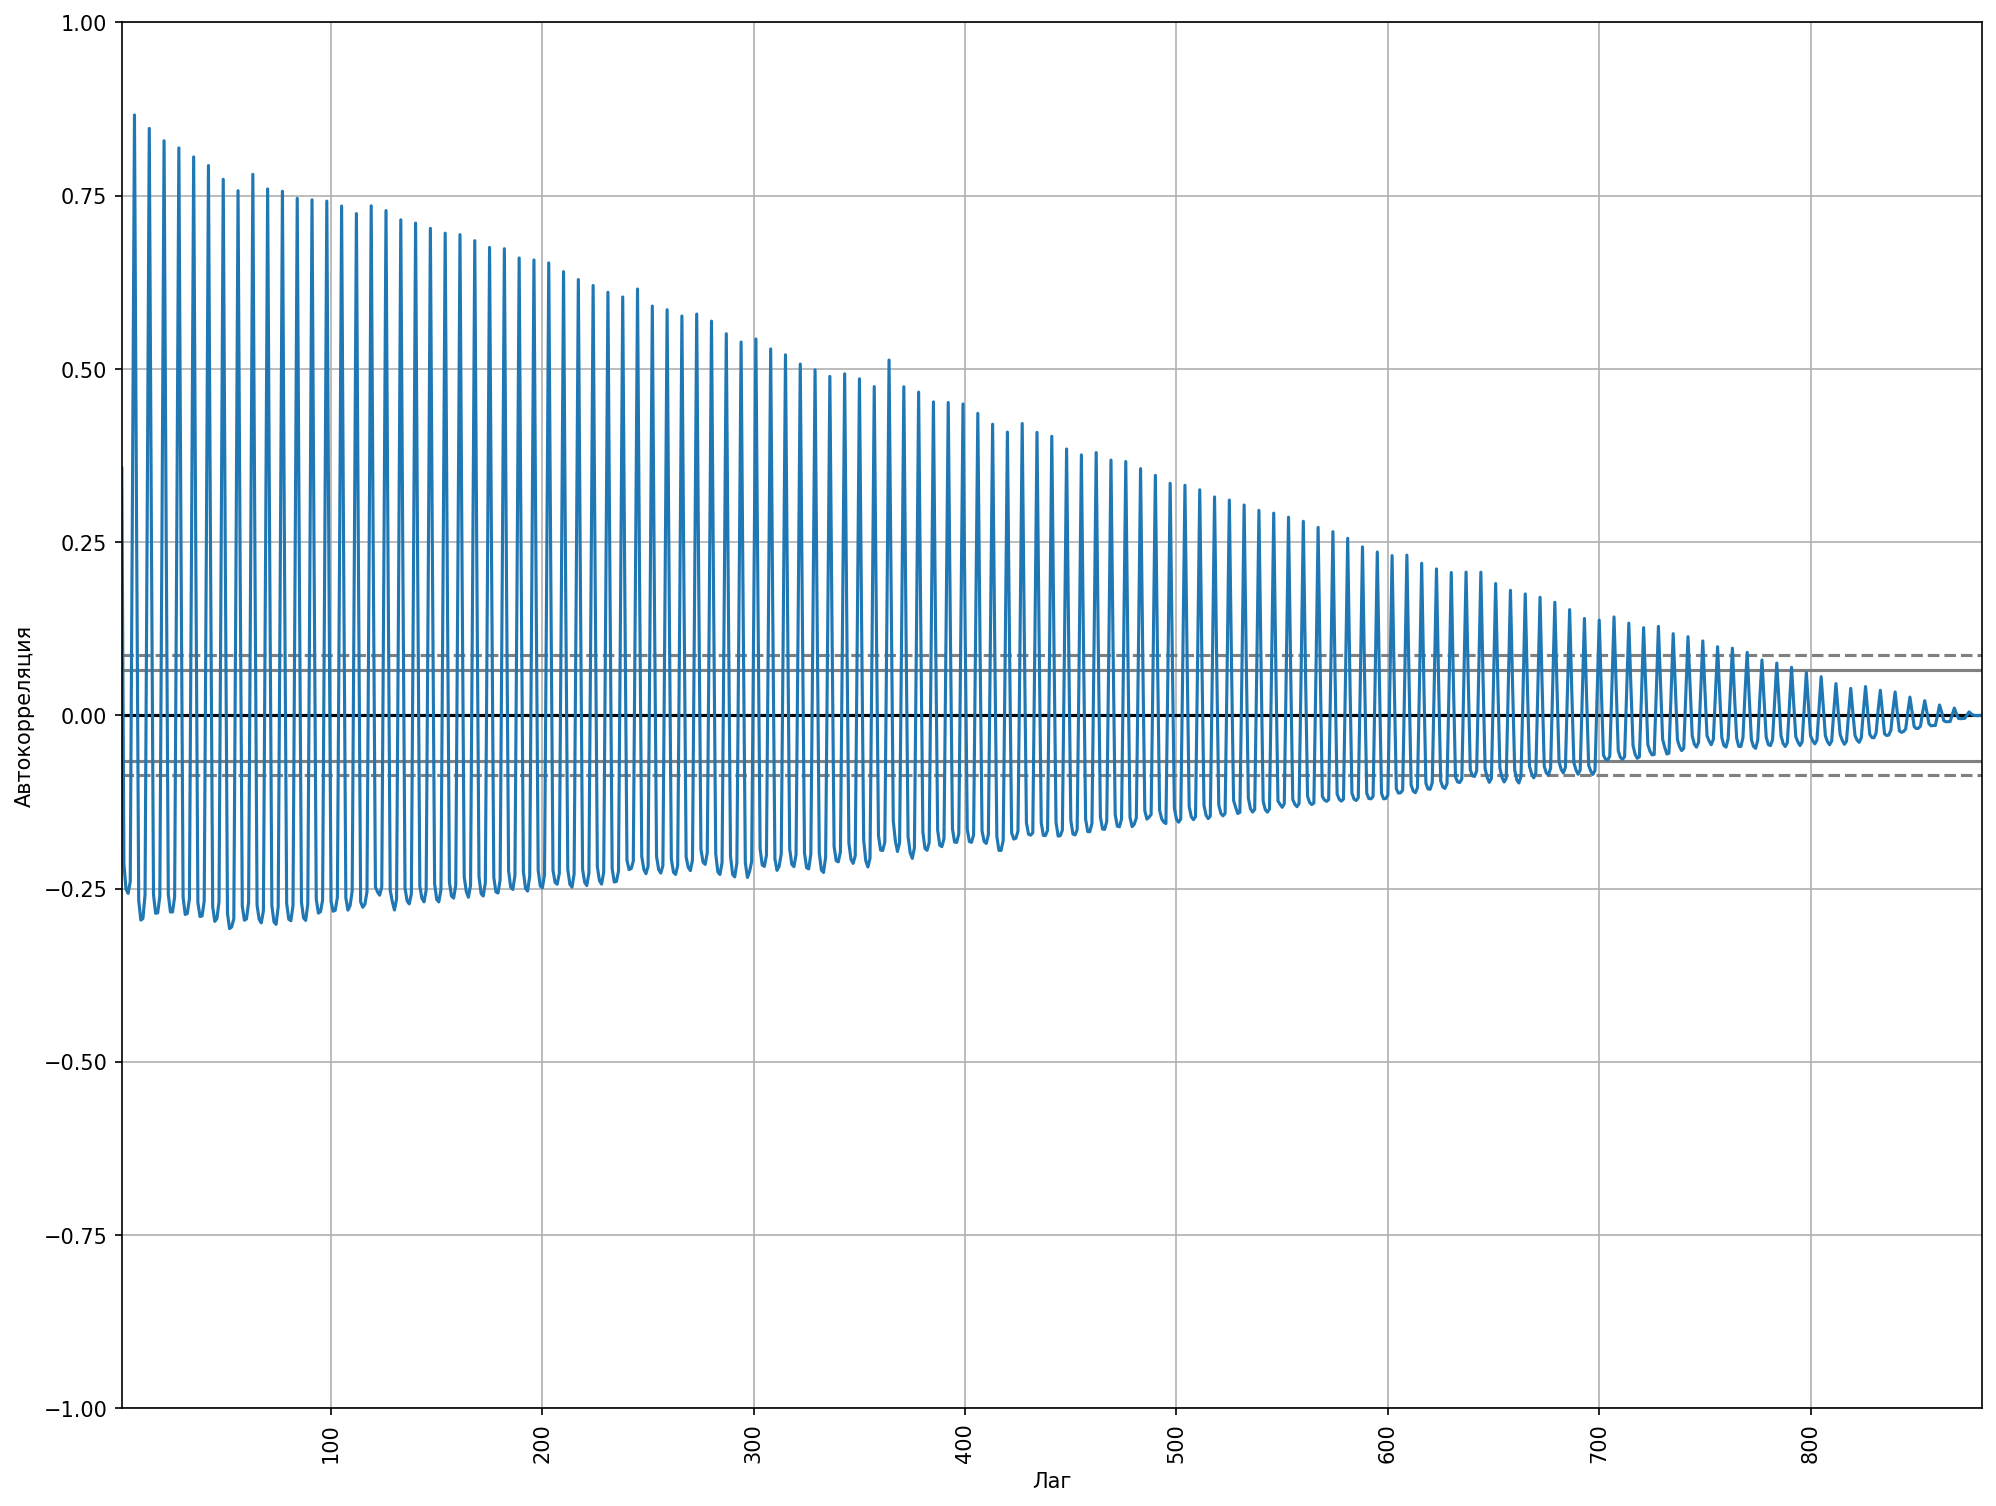

<Figure size 640x480 with 0 Axes>

In [8]:

acf = sm.tsa.acf(grouped_data['total'])

plt.figure(figsize=(16,12), dpi=150)
pd.plotting.autocorrelation_plot(grouped_data['total']).plot()
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.xticks(rotation=90)
plt.show()
plt.savefig('2.jpg', format ='jpg', dpi=300)

### 5
Находим оконное преобразование Фурье, где нужно подобрать оптимальные размеры окна
На практике нет возможности получить сигнал на бесконечном интервале, так как нет возможности узнать, какой был сигнал до включения устройства и какой он будет в будущем. Ограничение интервала анализа равносильно произведению исходного сигнала на прямоугольную оконную функцию. Таким образом, результатом оконного преобразования Фурье является не спектр исходного сигнала, а спектр произведения сигнала и оконной функции. В результате возникает эффект, называемый растеканием спектра сигнала. Опасность заключается в том, что боковые лепестки сигнала более высокой амплитуды могут маскировать присутствие других сигналов меньшей амплитуды.

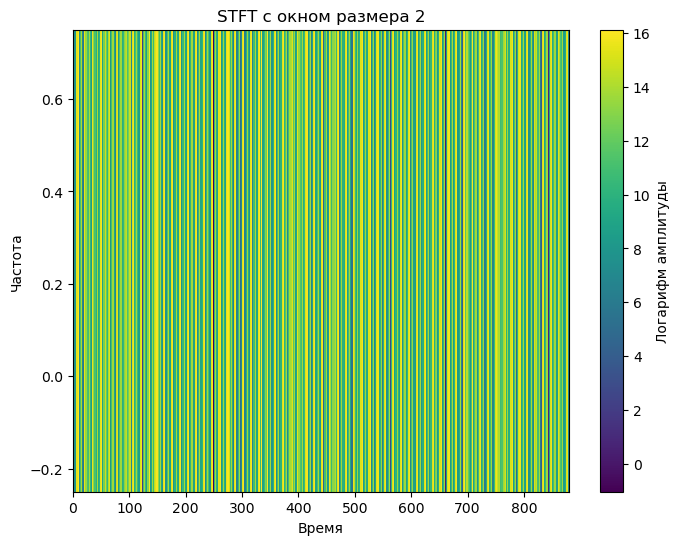

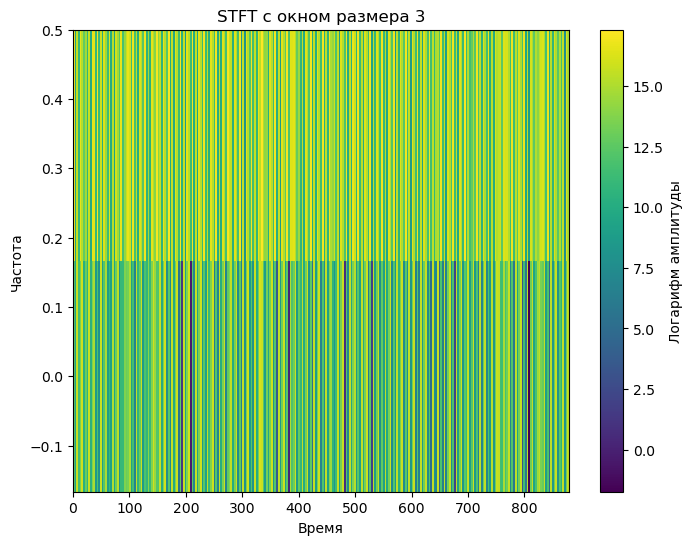

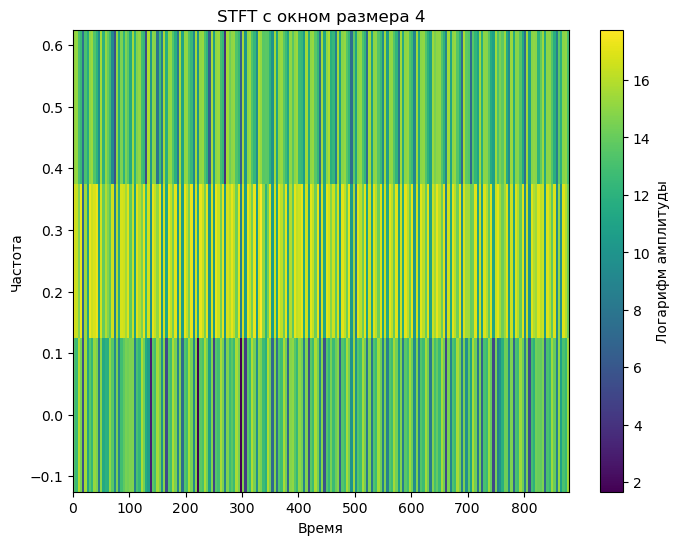

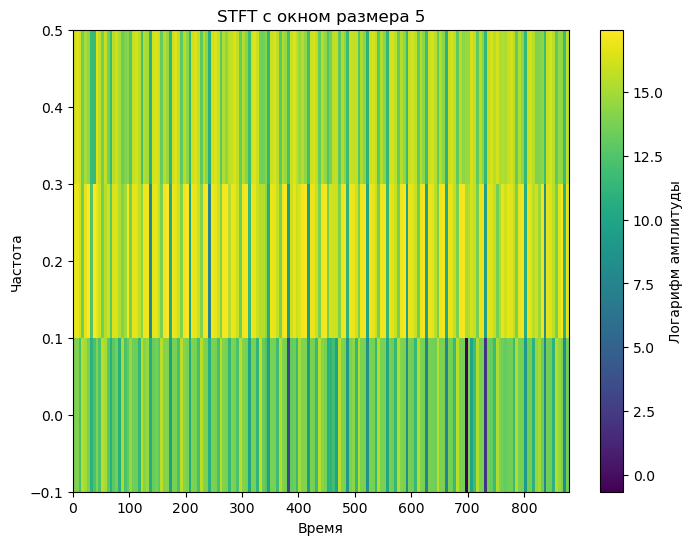

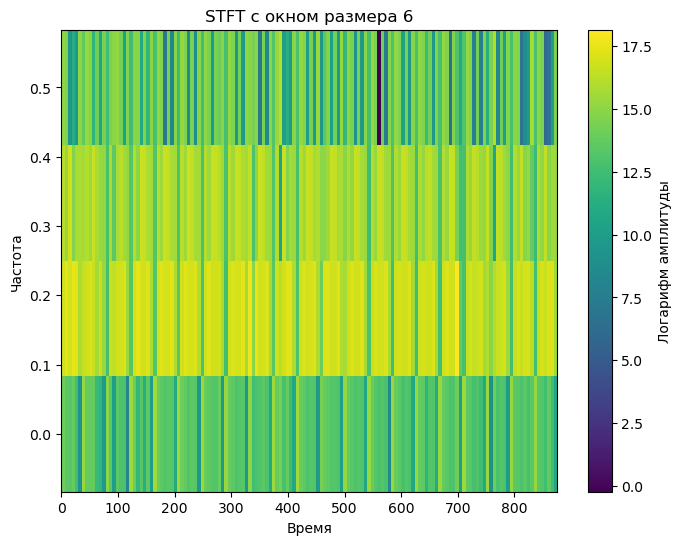

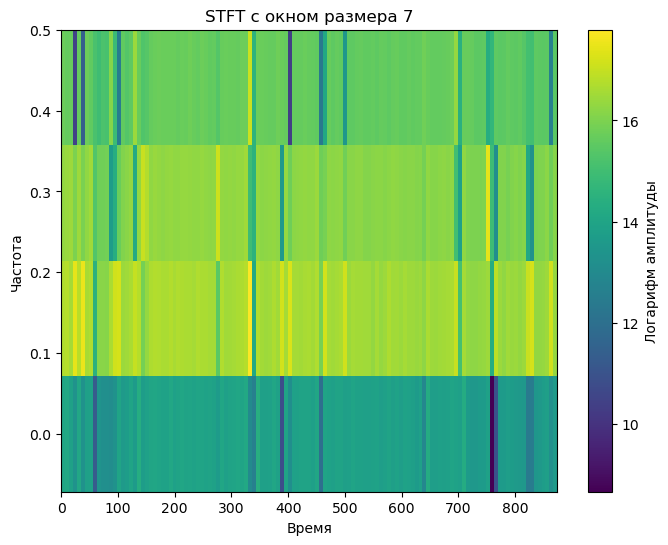

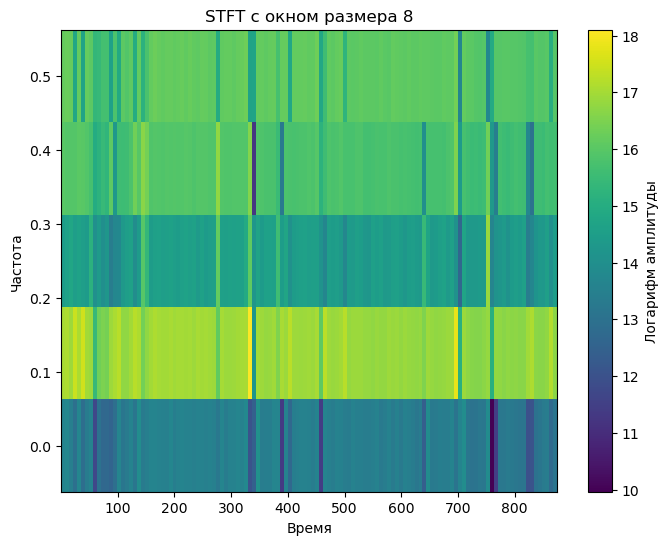

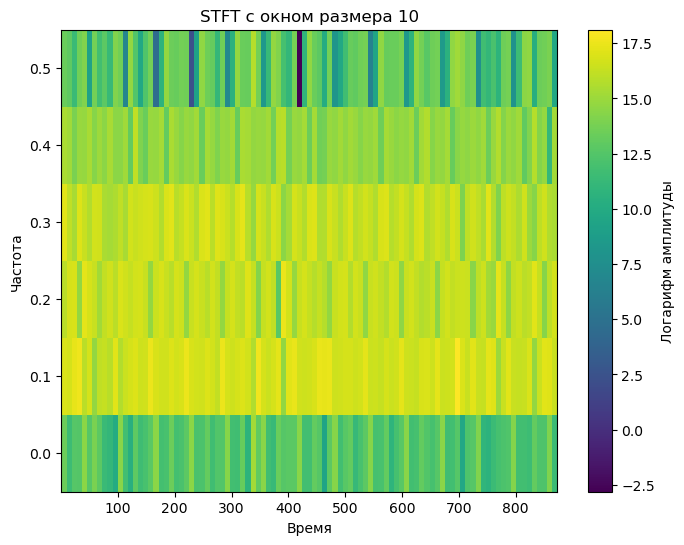

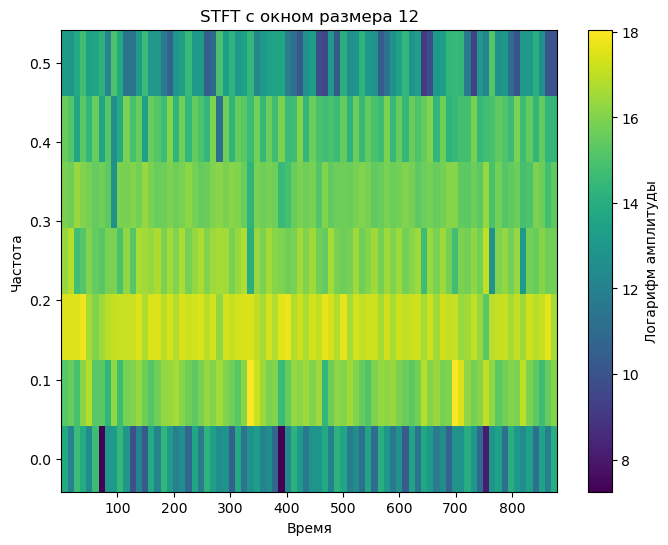

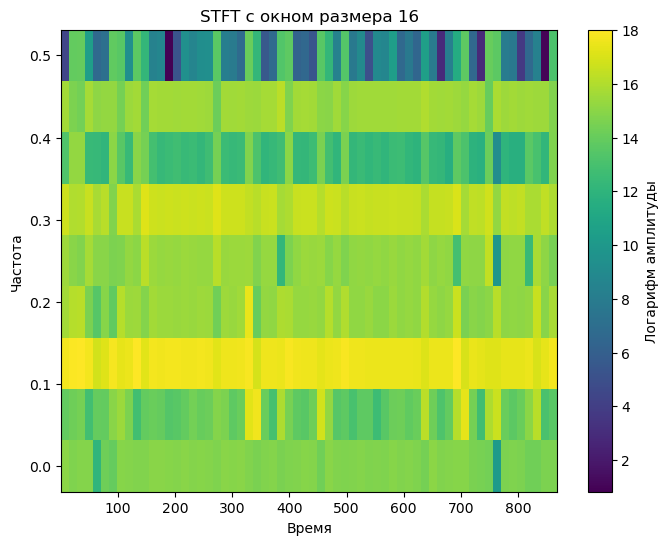

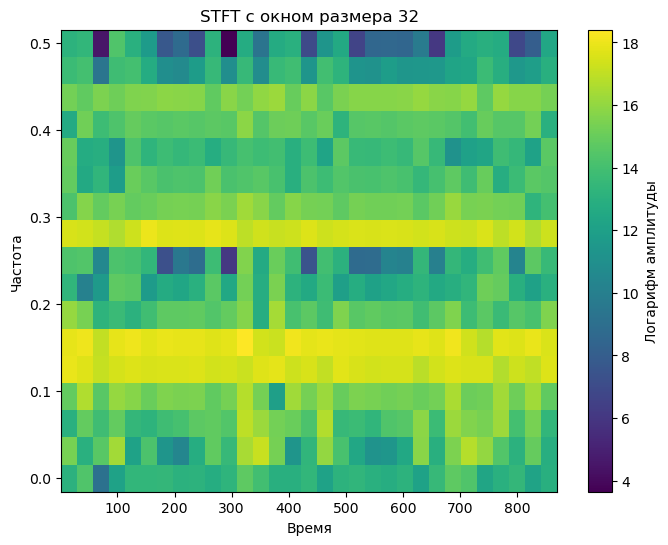

In [9]:
data = grouped_data['total'].dropna().values
# Различные размеры окон для применения в STFT
window_sizes = [2, 3, 4, 5, 6, 7, 8, 10, 12, 16,
                32]  # Пример различных размеров окон

# Применение окон различных размеров для STFT и построение спектрограммы для каждого
for size in window_sizes:
    frequencies, time_segments, stft_data = spectrogram(data,
                                                        fs=1.0,
                                                        nperseg=size)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(time_segments, frequencies, np.log(stft_data))
    plt.title(f'STFT с окном размера {size}')
    plt.xlabel('Время')
    plt.ylabel('Частота')
    plt.colorbar().set_label('Логарифм амплитуды')
    plt.show()

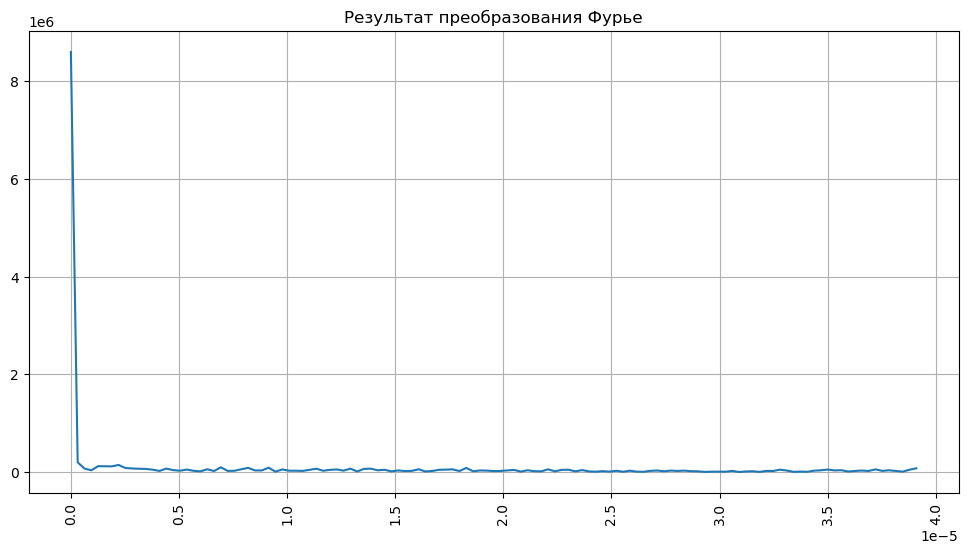

<Figure size 640x480 with 0 Axes>

In [10]:
val = grouped_data['total'].values
X = fft(val)
N = len(X)
n = np.arange(N)
# get the sampling rate
sr = 1 / (60 * 60)
T = N / sr
freq = n / T

# Get the one-sided specturm
n_oneside = N // 7 # делить на количество окон
# get the one side frequency
f_oneside = freq[:n_oneside]

plt.figure(figsize=(12,6), dpi=100)
plt.plot(f_oneside, np.abs(X[:n_oneside]))
plt.title('Результат преобразования Фурье')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()
plt.savefig('3.jpg', format ='jpg', dpi=300)

### 6
Для всей частотной и временной области находим вейвлет Хаара
Преобразование Хаара используется для сжатия входных сигналов, компрессии изображений, в основном цветных и черно-белых с плавными переходами. Идеален для картинок типа рентгеновских снимков. Данный вид архивации известен довольно давно и напрямую исходит из идеи использования когерентности областей. Степень сжатия задается и варьируется в пределах 5-100. При попытке задать больший коэффициент на резких границах, особенно проходящих по диагонали, проявляется «лестничный эффект» — ступеньки разной яркости размером в несколько пикселов.

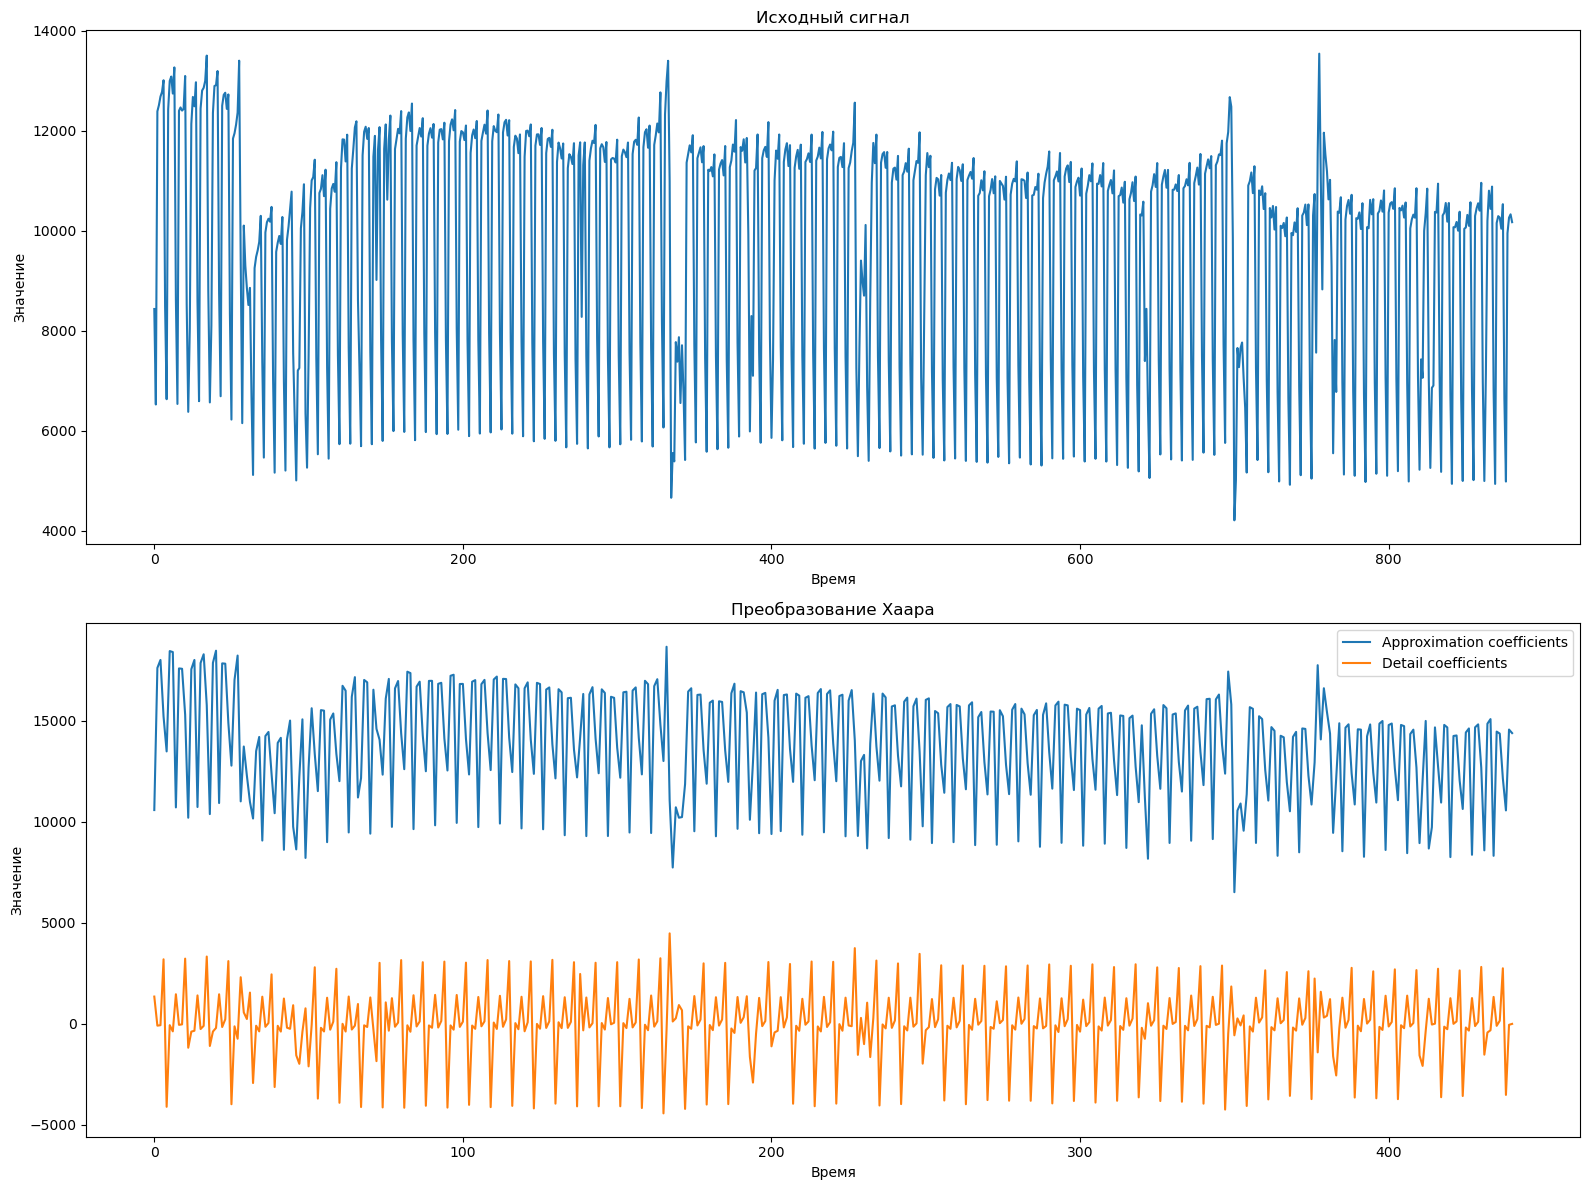

<Figure size 640x480 with 0 Axes>

In [11]:
val = grouped_data['total'].dropna().values
c_a = pywt.dwt(val, "haar")

# Визуализация результатов
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
plt.plot(val)
plt.title('Исходный сигнал')
plt.xlabel('Время')
plt.ylabel('Значение')

plt.subplot(2, 1, 2)
plt.plot(c_a[0], label='Approximation coefficients')  # Аппроксимационные коэффициенты
plt.plot(c_a[1], label='Detail coefficients')  # Детальные коэффициенты
plt.legend()
plt.title('Преобразование Хаара')
plt.xlabel('Время')
plt.ylabel('Значение')

plt.tight_layout()
plt.show()
plt.savefig('4.jpg', format ='jpg', dpi=300)

### 7
Частотно-временную локализацию вейвлета
Частотно-временная локализация вейвлета - это способность вейвлета отображать как частотные, так и временные характеристики сигнала. Вейвлеты обеспечивают эффективное представление сигналов во временно-частотной области, позволяя анализировать сигналы с разной частотной информацией в разные моменты времени.
Частотно-временная локализация вейвлета позволяет исследовать, какие частоты преобладают в сигнале в разные моменты времени. Это позволяет обнаруживать временные изменения в частотной структуре сигнала. Вейвлеты обладают свойством детектировать короткосрочные и долгосрочные временные структуры сигнала, что делает их полезными для анализа нестационарных сигналов.
Путем применения вейвлетного преобразования к сигналу и визуализации результатов можно увидеть, как вейвлет "сжимается" и "растягивается" во времени и частоте в зависимости от характеристик сигнала в конкретные моменты времени. Такая локализация помогает выявлять различные компоненты сигнала в разных частях его длительности и частотной характеристики.

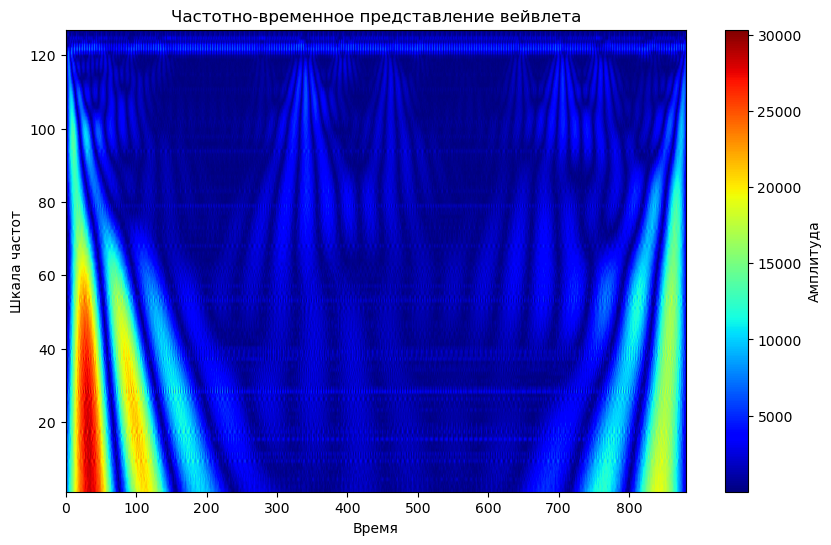

<Figure size 640x480 with 0 Axes>

In [12]:
# Извлечение данных из столбца 'total'
data = grouped_data['total'].dropna().values

# Создание шкалы частот и времени для анализа
scales = np.arange(1, 128)  # Выбор шкалы частот

# Выполнение непрерывного вейвлет-преобразования
cwtmatr, freqs = pywt.cwt(data, scales,
                          'morl')  # Выбор вейвлета, например, 'morl'

# Построение частотно-временного представления вейвлета
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(cwtmatr),
           extent=[0,
               len(grouped_data.index),
               min(scales),
               max(scales)
           ],
           aspect='auto',
           cmap='jet')
plt.colorbar(label='Амплитуда')
plt.title('Частотно-временное представление вейвлета')
plt.xlabel('Время')
plt.ylabel('Шкала частот')
plt.show()
plt.savefig('5.jpg', format ='jpg', dpi=300)

### 8
Спектр вейвлета
Спектр вейвлета представляет собой его частотную характеристику. Это графическое представление показывает, какие частоты вейвлет способен обнаружить в сигнале при различных масштабах (или частотах) и как эти частоты варьируются во времени.
Спектр вейвлета - это график зависимости частотной составляющей вейвлета от его масштаба (или обратно, от его частоты). Он помогает определить, какие частоты вейвлет способен локализовать в сигнале в зависимости от его положения во времени. Это позволяет исследовать частотную информацию сигнала на различных временных отрезках.
Обычно спектр вейвлета отображает относительную чувствительность вейвлета к различным частотам в зависимости от масштаба. Это позволяет анализировать не только частоты, которые вейвлет хорошо выделяет, но и его чувствительность к этим частотам в разные моменты времени.
Спектр вейвлета является важным инструментом для понимания частотной разрешимости вейвлетного преобразования и его способности анализировать разные частоты в сигнале в зависимости от их временной локализации.

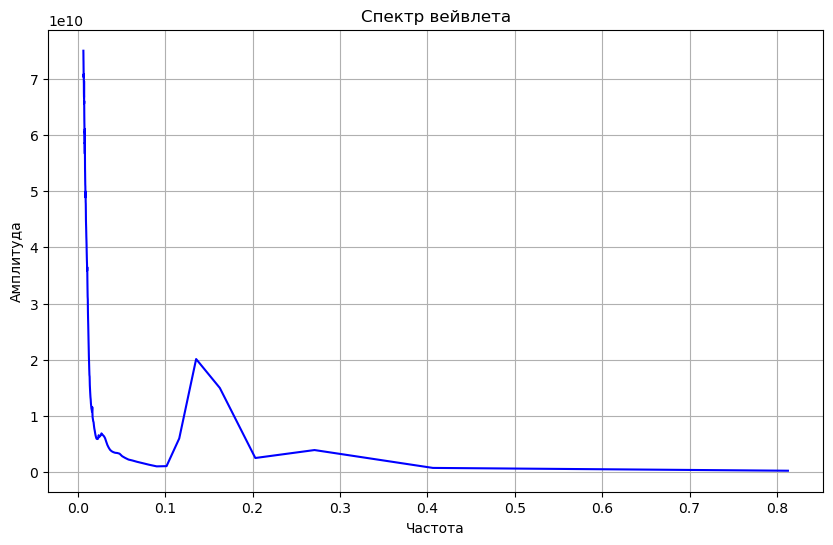

<Figure size 640x480 with 0 Axes>

In [13]:
# Создание шкалы частот для анализа
scales = np.arange(1, 128)  # Выбор шкалы частот

# Выполнение непрерывного вейвлет-преобразования Морле на основе временного ряда 'total'
cwtmatr, freqs = pywt.cwt(data, scales, 'morl')  # Выбор вейвлета, например, 'morl'

# Нахождение спектра вейвлета
wavelet_spectrum = np.sum(np.abs(cwtmatr) ** 2, axis=1)  # Расчет спектра вейвлета

# Построение графика спектра вейвлета
plt.figure(figsize=(10, 6))
plt.plot(freqs, wavelet_spectrum, color='blue')
plt.title('Спектр вейвлета')
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.show()
plt.savefig('6.jpg', format ='jpg', dpi=300)

### 9
Сравнение п.5 и п.6
    При изменении размера окна в оконном преобразовании Фурье мы либо получаем высокую точность относительно частоты, но при этом очень низкую точность относительно времени, либо наоборот высокую точность относительно времени, и низкую относительно частоты. Основное различие лежит в следующем: преобразование Фурье раскладывает сигнал на составляющие в виде синусов и косинусов, т.е. функций, локализованных в Фурье-пространстве; напротив, вейвлет-преобразование использует функции, локализованные как в реальном, так и в Фурье-пространстве.
    Таким образом, вейвлет-преобразования, в отличии от оконного преобразования Фурье, которое имеет постоянный масштаб в любой момент времени для всех частот, имеет лучшее представление времени и худшее представление частоты на низких частотах сигнала и лучшее представление частоты с худшим представлением времени на высоких частотах сигнала.
    Исходя из сравнения предыдущих графиков можно сделать вывод, что мы получили больше информации об исходной функции и можем теперь начинать фильтровать и восстанавливать сигнал.

### 10
Свертка из п.5 и п.6
Свертка между оконным преобразованием Фурье (STFT) и вейвлетом Хаара представляет собой процесс, в котором результаты оконного преобразования Фурье (STFT) и вейвлетного преобразования (в данном случае - вейвлета Хаара) сворачиваются друг с другом.
STFT используется для анализа частотных компонентов сигнала во времени с помощью применения оконного преобразования Фурье на коротких временных отрезках сигнала. Вейвлет Хаара, с другой стороны, является вейвлетом, который обладает свойствами быстрого локального изменения, хорошо локализован во времени и имеет простую структуру.
Свертка между результатами STFT и вейвлетного преобразования Хаара позволяет выявить, как различные частотные компоненты, обнаруженные с помощью STFT, коррелируют с особенностями, выявленными вейвлетом Хаара. Это позволяет выделить специфические характеристики сигнала, которые выявлены обоими методами одновременно и показывает, как частотные компоненты сигнала коррелируют с его временными особенностями.
Такая свертка может помочь выявить значимые особенности сигнала, которые могут быть локализованы как во времени, так и в частотной области, используя комбинацию методов анализа.

C:\Download\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


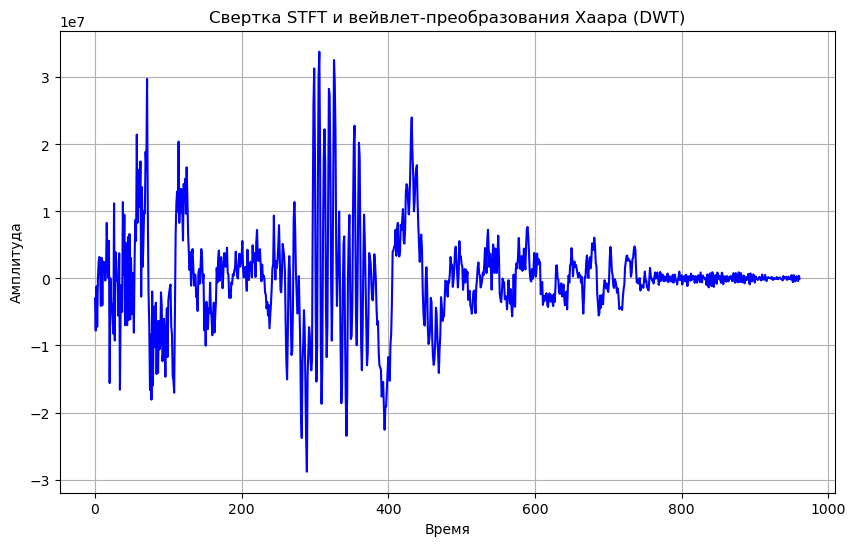

<Figure size 640x480 with 0 Axes>

In [14]:
# Получение результатов оконного преобразования Фурье (STFT)
frequencies, time_segments, stft_data = stft(
    data, fs=0.5, nperseg=50)  # Параметры могут варьироваться

# Выполнение дискретного вейвлет-преобразования Хаара (DWT)
wavelet = 'haar'
wavelet_coeffs = pywt.dwt(stft_data.flatten(), wavelet)

# Свертка между результатами STFT и вейвлет-преобразования Хаара (DWT)
convolution_result = np.convolve(stft_data.flatten(),
                                 wavelet_coeffs[0],
                                 mode='same')

# Построение графика свертки
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(convolution_result)), convolution_result, color='blue')
plt.title('Свертка STFT и вейвлет-преобразования Хаара (DWT)')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.show()
plt.savefig('7.jpg', format ='jpg', dpi=300)

### 11
Проводим пороговую фильтрацию сигнала, которая позволяет избавиться от резких и ненужных всплесков

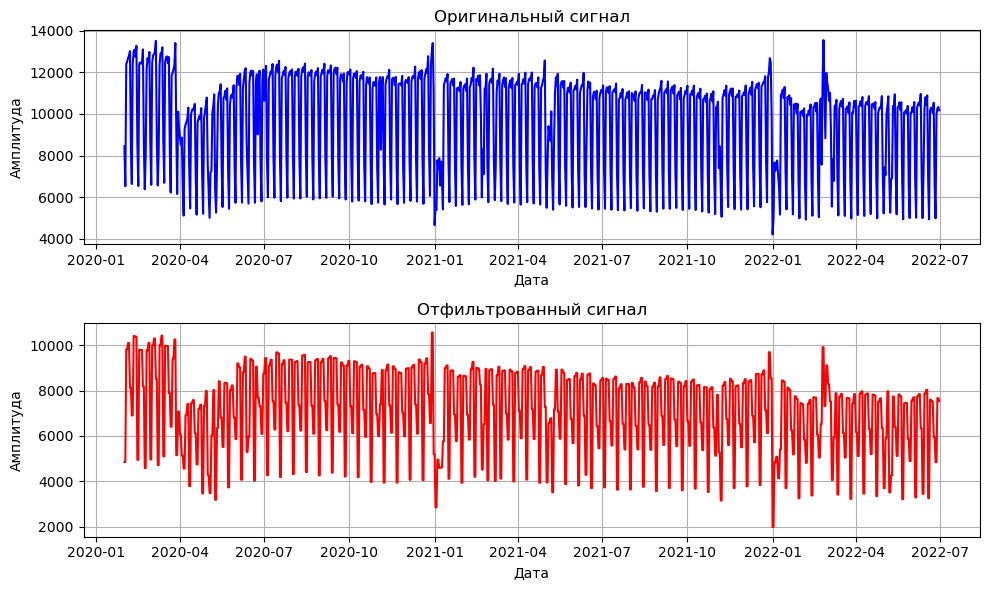

<Figure size 640x480 with 0 Axes>

In [15]:
# Выполнение дискретного вейвлет-преобразования Хаара (DWT)
wavelet = 'haar'
wavelet_coeffs = pywt.dwt(data, wavelet)

# Определение порога
threshold = np.std(
    wavelet_coeffs[-1])*2 

# Применение пороговой фильтрации к коэффициентам вейвлет-преобразования
thresholded_coeffs = pywt.threshold(wavelet_coeffs[0], threshold, mode='soft')

# Обратное вейвлет-преобразование для восстановления сигнала
filtered_signal = pywt.idwt(thresholded_coeffs, None, wavelet)

# Создание DataFrame с данными
index_length = len(grouped_data.index)
filtered_signal = filtered_signal[:
                                            index_length]  # Приведение длины reconstructed_signal к длине grouped_data.index
new_df = pd.DataFrame({
    'Date': grouped_data.index,
    'Dataset': filtered_signal
})
new_df = new_df.set_index('Date')
# Построение графиков оригинального и отфильтрованного сигналов
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(grouped_data.index, grouped_data['total'], color='blue')
plt.title('Оригинальный сигнал')
plt.xlabel('Дата')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(new_df.index, new_df['Dataset'], color='red')
plt.title('Отфильтрованный сигнал')
plt.xlabel('Дата')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('8.jpg', format ='jpg', dpi=300)

### 12
Проводим восстановление сигнала с помощью быстрого обратного преобразования Фурье

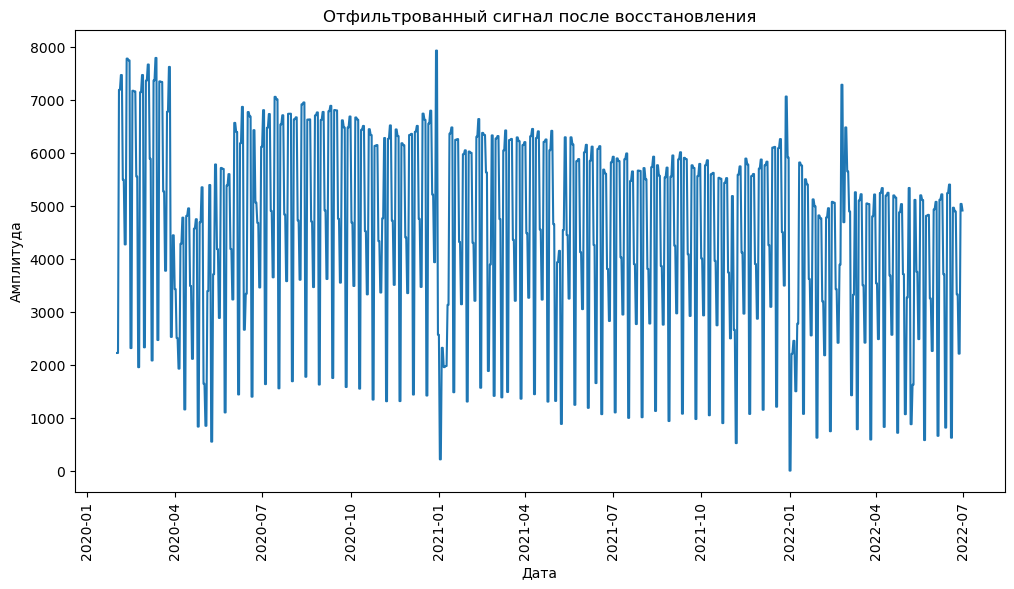

<Figure size 640x480 with 0 Axes>

In [16]:
# Определение порога
threshold = np.std(wavelet_coeffs[-1]) * 4  # Пример порога (стандартное отклонение * 2)

# Применение пороговой фильтрации к коэффициентам вейвлет-преобразования
thresholded_coeffs = pywt.threshold(wavelet_coeffs[0], threshold, mode='soft')

# Обратное вейвлет-преобразование для восстановления сигнала
filtered_signal = pywt.idwt(thresholded_coeffs, None, wavelet)

# Выравниваем длины индекса и значений сигнала
if len(grouped_data.index) != len(filtered_signal):
    grouped_data_index = grouped_data.index[:len(filtered_signal)]
    filtered_signal = filtered_signal[:len(grouped_data.index)]
else:
    grouped_data_index = grouped_data.index

# Создаем DataFrame с колонкой 'total' из значений сигнала и 'dots' в качестве индекса
r_df = pd.DataFrame({'total': filtered_signal}, index= grouped_data_index)

# Строим график
plt.figure(figsize=(12,6), dpi=100)
plt.plot(grouped_data_index, filtered_signal)
plt.title('Отфильтрованный сигнал после восстановления')
plt.xlabel('Дата')
plt.ylabel('Амплитуда')
plt.xticks(rotation=90)
plt.show()
plt.savefig('9.jpg', format ='jpg', dpi=300)

### 13
Свертка исходного и востановленного сигнала
Свертка между исходным и восстановленным сигналами позволяет оценить степень совпадения между ними и выделить различия или сходства в их формах. Этот процесс выполняется путем выполнения операции свертки, которая является математической операцией объединения двух функций и позволяет увидеть, где и как сигналы совпадают или расходятся друг относительно друга.
Если свертка исходного и восстановленного сигналов дает какой-то результат, это может указывать на то, что восстановленный сигнал хорошо соответствует исходному. Однако, если свертка показывает значительные различия, это может свидетельствовать о том, что восстановление сигнала не является точным или что восстановленный сигнал не полностью совпадает с исходным.
Анализ свертки может помочь в определении степени точности восстановления сигнала и выявлении областей, где восстановленный сигнал отличается от исходного. Это может быть важно для оценки качества методов восстановления сигналов и определения областей, требующих дополнительной коррекции или улучшения.

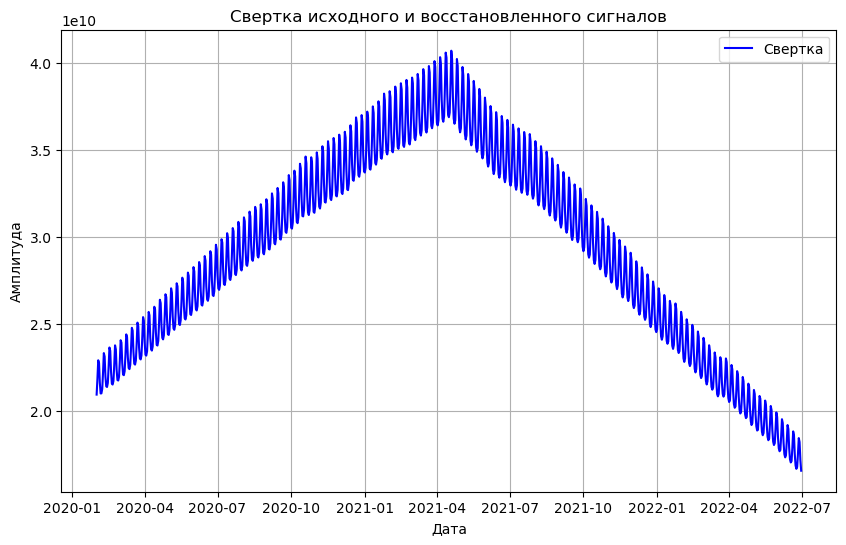

<Figure size 640x480 with 0 Axes>

In [17]:
 
# Построение графика отфильтрованного сигнала
plt.figure(figsize=(10, 6))
    
# Свертка исходного и восстановленного сигналов
convolution_result = np.convolve(data, filtered_signal, mode='same')

if len(grouped_data.index) != len(convolution_result):
    grouped_data_index = grouped_data.index[:len(convolution_result)]
    filtered_signal = convolution_result[:len(grouped_data.index)]
else:
    grouped_data_index = grouped_data.index
    
plt.plot(grouped_data_index,convolution_result, color='blue', label='Свертка')

plt.title('Свертка исходного и восстановленного сигналов')
plt.xlabel('Дата')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('10.jpg', format ='jpg', dpi=300)

### 14
Находим меру близости и схожести исходного и восстановленного сигналов. Т.е. сравниваем среднеквадратичные отклонения, а также квадратичные отклонения исходного и восстановленного сигналов.

In [18]:
# Вычисление коэффициента корреляции Пирсона
correlation_coefficient, _ = pearsonr(data, filtered_signal)
print(f"Коэффициент корреляции Пирсона: {correlation_coefficient}")

# Вычисление средней абсолютной ошибки (MAE)
mae = mean_absolute_error(data, filtered_signal)
print(f"Средняя абсолютная ошибка (MAE): {mae}")

Коэффициент корреляции Пирсона: 0.8285660040944818
Средняя абсолютная ошибка (MAE): 5256.809314453539


Если будуте показывать ковыневу, то он задаст много вопросов на счет последнего пункта. Так что лучше придумайте свое.